# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [143]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [144]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', ';')

In [145]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Demographics Germany: Rows: {} Columns {}'.format(azdias.shape[0], azdias.shape[1]))

#azdias.head(15)


Demographics Germany: Rows: 891221 Columns 85


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [146]:
# Identify missing or unknown data values and convert them to NaNs.
#azdias.isnull().sum()


In [147]:
feat_info.missing_or_unknown.str.split()[0][0][0] 

'['

In [148]:
# create function to take in list of string and create new list
def str_parse(string):
    l = []
    string = string[:-1]
    string = string[1:]
    return string.split(',')
    
    
    

feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(str_parse)

In [149]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [150]:
# Make a copy of azdias to be able to compare the 2
azdias2 = azdias.copy()

In [151]:
# For cameo_deug15, we have to remove the last string
#azdias['CAMEO_DEUG_2015'].apply(lambda x: x[:-1])
azdias['CAMEO_DEUG_2015'].value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64

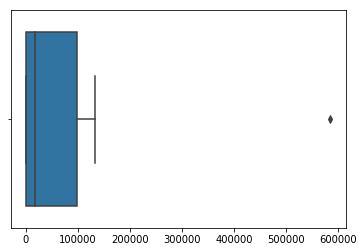

In [152]:
sns.boxplot(azdias.isnull().sum());

In [153]:
# for col in azdias.columns:
#     print(azdias[col].value_counts())

### My Work

There are a few columns that have a problem that we will need to clean up

- `MIN_GEBAEUDEJAHR` : this column
- `CAMEO_DEUG_2015`: this had some W's in it and some values needed to be converted.
- `OST_WEST_KZ`
- `CAMEO_DEU_2015`
- `CAMEO_INTL_2015`

In [154]:
# change everything to float besides some of the other columns
for col in azdias.columns:
    if col != "MIN_GEBAEUDEJAHR" and col != 'CAMEO_DEUG_2015' and col != 'OST_WEST_KZ' and col != 'CAMEO_DEU_2015' and col != 'CAMEO_INTL_2015':
        azdias[col] = azdias[col].astype(float)

# lets take a look at these columns individually
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X': np.nan})

azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace({'XX': np.nan})

azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX': np.nan})

In [155]:
# for all of the columns in azdias, if the value is equal to the value in missing_or_unknown in feat_info, convert to nan
%time
l = []



# loop through the aZdias columns, the feat_info rows, where they match, loop through miss_or_unknown -- 
# for each number in that row, map that number in azdias to np.NAN
for az_col in azdias.columns:
    for feat_row in feat_info.attribute:
        if az_col == feat_row:
            # skip over these columns because they were already converted
            if az_col != "MIN_GEBAEUDEJAHR" and az_col != 'CAMEO_DEUG_2015' and az_col != 'OST_WEST_KZ' and az_col != 'CAMEO_DEU_2015' and az_col != 'CAMEO_INTL_2015':
            
                # get list of missing_or_unknown
                l = feat_info[feat_info.attribute == az_col].missing_or_unknown.values[0]
                #convert list to float
                if len(l[0]) > 0:
                    # for every number in the list, run a map on azdias[az_col] to change the num to np.Nan
                    for ch in l:

                        ch = float(ch)

                        # must give condition: if number is in list (ch) and it matches azdias[az_col]

                        azdias[az_col] = azdias[az_col].replace({ch: np.NAN})
                        print('column: {}, value: {}'.format(az_col, azdias[az_col]))



CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 685 µs
column: AGER_TYP, value: 0         NaN
1         NaN
2         NaN
3         2.0
4         NaN
5         3.0
6         NaN
7         NaN
8         NaN
9         NaN
10        0.0
11        NaN
12        NaN
13        NaN
14        NaN
15        1.0
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        2.0
         ... 
891191    1.0
891192    NaN
891193    2.0
891194    NaN
891195    2.0
891196    NaN
891197    NaN
891198    NaN
891199    NaN
891200    NaN
891201    NaN
891202    NaN
891203    NaN
891204    NaN
891205    1.0
891206    NaN
891207    1.0
891208    NaN
891209    NaN
891210    NaN
891211    NaN
891212    NaN
891213    NaN
891214    NaN
891215    NaN
891216    NaN
891217    NaN
891218    NaN
891219    NaN
891220    NaN
Name: AGER_TYP, Length: 891221, dtype: float64
column: A

In [156]:
# checking the azdias if needed
#azdias.isnull().sum()

In [157]:
# check against the copy
# azdias2.isnull().sum()

### My work ***

For this lookup here, each value would have an amount under the list. Would need to say, for example, if the value type was -1 for this, it would need to be Nan, if the value type was 0, it would need to be Nan. This may need to be a lambda function.

- map a series of AGER_TYP using the list from `feat_info.missing_or_unknown`
- go through the list of missing or unknown and map the list to Nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

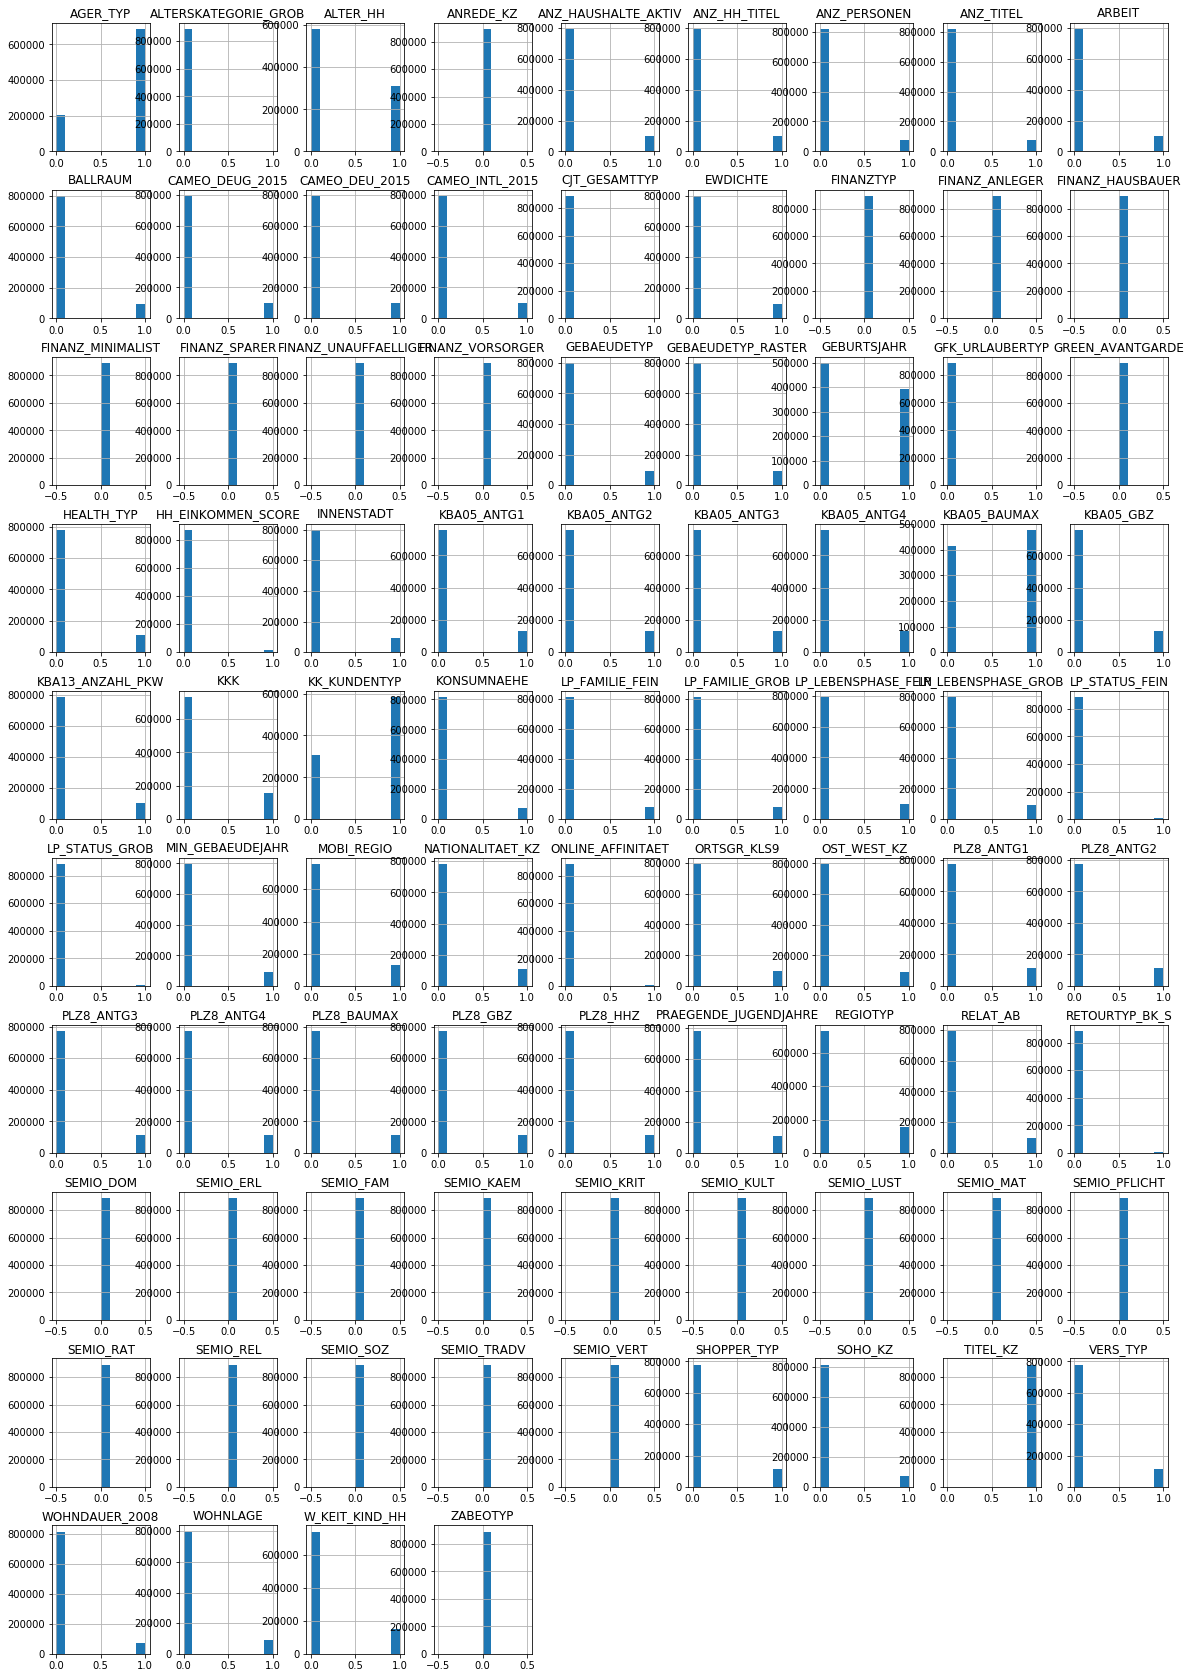

In [158]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().hist(figsize=(20,30));


In [159]:
# Investigate patterns in the amount of missing data in each column.
# `AGER_TYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, `TITEL_KZ` all missing too much data
azdias.drop(labels=['AGER_TYP','KBA05_BAUMAX','GEBURTSJAHR','TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP'], axis=1, inplace=True)
azdias.shape

(891221, 79)

In [160]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#azdias.ALTER_HH.isnull().mean()
azdias.SHOPPER_TYP.isnull().mean()


0.12476815514894735

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- `AGER_TYP` : this cell was removed because 76% of the information was unknown. This cell speaks to persons who are elderly. We do not have sufficient data for this attribute.
- `KBA05_BAUMAX` : this attribute was removed because 38% of the data was missing. This attribute is the building type.
- `GEBURTSJAHR` : 44% data was missing for this attribute.
- `TITEL_KZ` : 91% of this data was missing. 
- `KK_KUNDENTYP` - 65% of this data was missing.

There are some patterns of missing values in the data. For example, in some of the variables, there are about 12%-13% of missing values in them (for a good amount of the data variables). This can show that some rows are probably outliers or are generally missing data and if we remove these rows it would take care of the outliers.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [161]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.b
# Take the rows that are outliers and put them in a separate dataframe, likewise the same for higher than 40.

azdias_g40 = azdias[azdias.isnull().sum(axis=1) > 10]
azdias_l40 = azdias[azdias.isnull().sum(axis=1) <= 10]


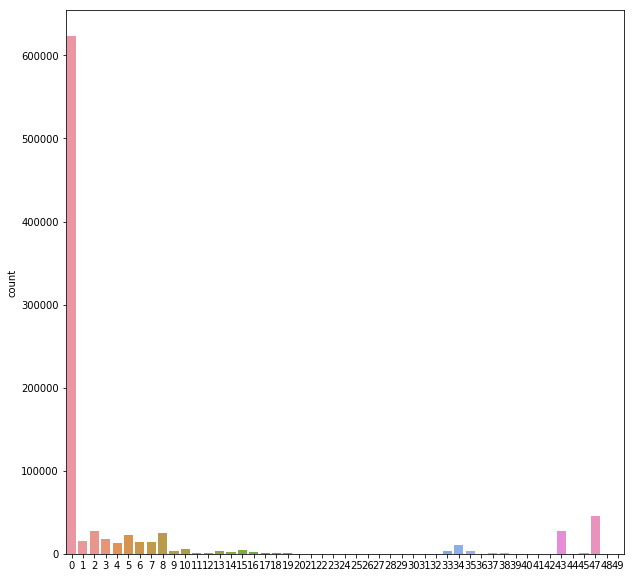

In [162]:
plt.subplots(figsize=(10,10))
sns.countplot(azdias.isnull().sum(axis=1).values);


In [163]:
azdias_l40.shape

(780153, 79)

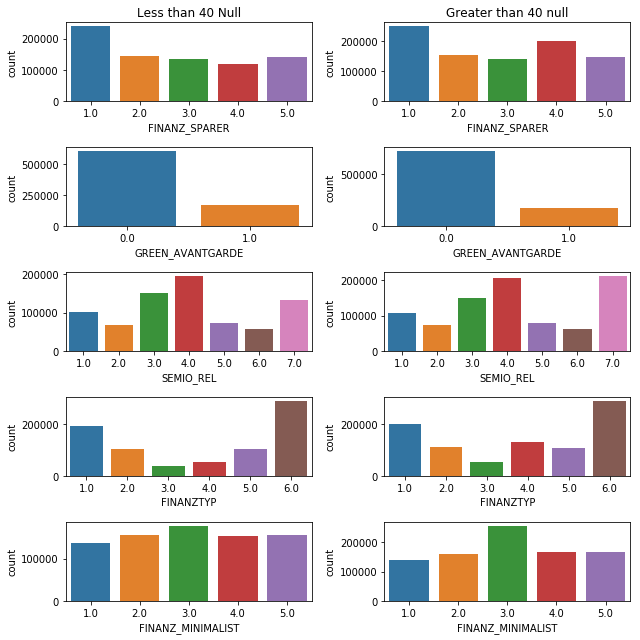

In [164]:
# trying to plot this differently from above
plt.close('all')
fig = plt.figure(figsize=(9,9))

ax1 = plt.subplot(5,2,1)
ax1.set_title('Less than 40 Null')
sns.countplot(azdias_l40.FINANZ_SPARER)

ax2 = plt.subplot(5,2,2)
ax2.set_title('Greater than 40 null')
sns.countplot(azdias.FINANZ_SPARER)

ax3 = plt.subplot(5,2,3)
sns.countplot(azdias_l40.GREEN_AVANTGARDE)

ax4 = plt.subplot(5,2,4)
sns.countplot(azdias.GREEN_AVANTGARDE)

ax5 = plt.subplot(5,2,5)
sns.countplot(azdias_l40.SEMIO_REL)

ax6 = plt.subplot(5,2,6)
sns.countplot(azdias.SEMIO_REL)

ax7 = plt.subplot(5,2,7)
sns.countplot(azdias_l40.FINANZTYP)

ax8 = plt.subplot(5,2,8)
sns.countplot(azdias.FINANZTYP)

ax9 = plt.subplot(5,2,9)
sns.countplot(azdias_l40.FINANZ_MINIMALIST)

ax10 = plt.subplot(5,2,10)
sns.countplot(azdias.FINANZ_MINIMALIST)


plt.tight_layout()


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After looking at the null values, everything after 10 null values are minimal when it comes to null rows.Also after looking at the comparison, and dropping the rows with more than 10 null values (outliers), we can see that we can easily remove these from the dataset without it having any major effects on the data. Looking at the distributions, they look roughly the same, so we can comfortably remove these rows from the dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [165]:
# How many features are there of each data type?
print('Ordinal Type: ',feat_info[feat_info.type == 'ordinal'].type.count())

print('Categorical Type: ',feat_info[feat_info.type == 'categorical'].type.count())

print('Mixed Type: ',feat_info[feat_info.type == 'mixed'].type.count())



Ordinal Type:  49
Categorical Type:  21
Mixed Type:  7


In [166]:
feat_info[feat_info.type == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [167]:
feat_info[feat_info.type == "mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [168]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
azdias_l40.CJT_GESAMTTYP.value_counts()

# CJT_GESAMTTYP has 6 values (int) --- one hot encoded
# FINANZTYP has 6 values (int) --- one hot encoded
# GFK_URLAUBERTYP has a number of values --- one hot encoded
# LP_FAMILIE_FEIN multivalue --- one hot encoded
# LP_FAMILIE_GROB multivalue --- one hot encoded (i can probably remove this as it is the same as previous)
# LP_STATUS_FEIN multivalue --- one hot encoded
# LP_STATUS_GROB multivalue --- one hot encoded (this may be able to remove as it is the same as previous)
# NATIONALITAET_KZ multivalue --- one hot encoded
# SHOPPER_TYP multivalue --- one hot encoded
# ZABEOTYP multivalue --- ont hot encoded
# KK_KUNDENTYP multivalue --- one hot encoded
# GEBAEUDETYP multivalue --- one hot encoded
# OST_WEST_KZ 2 values. this will need to reencode the values as numbers
# CAMEO_DEUG_2015 multivalue --- ont hoe encoded
# CAMEO_DEU_2015 this is a strange value and would need to be created dummy variables


4.0    193491
3.0    143625
2.0    139638
5.0    109291
6.0     98948
1.0     91326
Name: CJT_GESAMTTYP, dtype: int64

In [169]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_dm = pd.get_dummies(azdias_l40, columns=["CJT_GESAMTTYP",'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                                   'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                                   'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
                           ,drop_first=True)



In [170]:
# OST_WEST_KZ has categorical strings so will map for it -  if it's west it will be 1, if its not it will be 0
azdias_dm.OST_WEST_KZ =azdias_dm.OST_WEST_KZ.map({'W': 1, '0': 0})

# dropping CAMEO_DEU_2015 as CAMEO_DEUG_2015 already has this roughly
azdias_dm.drop(labels='CAMEO_DEU_2015', axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept almost all of the features as the more information we can collect the better. However, I dropped `CAMEO_DEU_2015` as we already had this information in the previous cell `CAMEO_DEUG_2015` roughly.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [171]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dm['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_dm.PRAEGENDE_JUGENDJAHRE.map({1:'Mainstream', 2:'Avantgarde', 3:'Mainstream', 4:'Avantgarde',
                                            5: 'Mainstream', 6:'Avantgarde', 7:'Avantgarde', 8:'Mainstream',
                                            9:'Avantgarde',10:'Mainstream', 11:'Avantgarde', 12: 'Mainstream',
                                            13: 'Avantgarde', 14:'Mainstream', 15: 'Avantgarde'})

azdias_dm['PRAEGENDE_JUGENDJAHRE_decades'] = azdias_dm.PRAEGENDE_JUGENDJAHRE.map({1:40, 2:40,3:50,4:50,5:60,
                                                                                 6:60,7:60,8:70,9:70,10:80,
                                                                                 11:80,12:80,13:80,14:90,15:90})

azdias_dm = pd.get_dummies(azdias_dm, columns=['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_decades'], drop_first=True)

azdias_dm.drop(labels=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)





In [172]:
'''
    Make function that converts the number to string, then takes the first digit and returns a string
    value based on that digit. 
'''
def wealth(input):
    input = str(input)
    if input[0] == '1':
        return "Wealthy Households"
    if input[0] == '2':
        return 'Prosperous Households'
    if input[0] == '3':
        return 'Comfortable Households'
    if input[0] == '4':
        return 'Less Affluent Households'
    if input[0] == '5':
        return 'Poorer Households'

In [173]:
azdias_dm['CAMEO_INTL_2015_wealth'] = azdias_dm.CAMEO_INTL_2015.map(lambda x:wealth(x))

In [174]:
def lifestages(input):
    input = str(input)
    if input[1] == '1':
        return "Pre-Family Couples & Singles"
    if input[1] == '2':
        return 'Young Couples With Children'
    if input[1] == '3':
        return 'Families With School Age Children'
    if input[1] == '4':
        return 'Older Families &  Mature Couples'
    if input[1] == '5':
        return 'Elders In Retirement'

In [175]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dm['CAMEO_INTL_2015_lifestages'] = azdias_dm.CAMEO_INTL_2015.map(lambda x:lifestages(x))


In [176]:
azdias_dm = pd.get_dummies(azdias_dm, columns=['CAMEO_INTL_2015_lifestages','CAMEO_INTL_2015_wealth'], drop_first=True)

azdias_dm = pd.get_dummies(azdias_dm, columns=['WOHNLAGE'], drop_first=True)

azdias_dm = pd.get_dummies(azdias_dm, columns=['PLZ8_BAUMAX'], drop_first=True)

azdias_dm.drop(labels=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], inplace=True, axis=1)

In [177]:
# Dropping `LP_LEBENSPHASE_FEIN` because it is already the same info as `CAMEO_INTL_2015_lifestages`
# `LP_LEBENSPHASE_GROB` can be dropped

#azdias_dm.WOHNLAGE.value_counts()

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- `LP_LEBENSPHASE_FEIN` has been dropped because it is roughly the same information as `CAMEO_INTL_2015_lifestages`.
- `LP_LEBENSPHASE_GROB` can be dropped because it as well has life stages which is also in `CAMEO_INTL_2015_lifestages`.
- `PLZ8_BAUMAX` can be dropped because we have similar data in `PLZ8_ANTG3`.
- `WOHNLAGE` was dropped because there is similar data for this.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [178]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [179]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [180]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # change everything to float besides some of the other columns
    
    for col in df.columns:
        if col != "MIN_GEBAEUDEJAHR" and col != 'CAMEO_DEUG_2015' and col != 'OST_WEST_KZ' and col != 'CAMEO_DEU_2015' and col != 'CAMEO_INTL_2015':
            df[col] = df[col].astype(float)

    # lets take a look at these columns individually
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan})

    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX': np.nan})

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX': np.nan})
    
    
    for az_col in df.columns:
        for feat_row in feat_info.attribute:
            if az_col == feat_row:
                # skip over these columns because they were already converted
                if az_col != "MIN_GEBAEUDEJAHR" and az_col != 'CAMEO_DEUG_2015' and az_col != 'OST_WEST_KZ' and az_col != 'CAMEO_DEU_2015' and az_col != 'CAMEO_INTL_2015':

                    # get list of missing_or_unknown
                    l = feat_info[feat_info.attribute == az_col].missing_or_unknown.values[0]
                    #convert list to float
                    if len(l[0]) > 0:
                        # for every number in the list, run a map on azdias[az_col] to change the num to np.Nan
                        for ch in l:

                            ch = float(ch)

                            # must give condition: if number is in list (ch) and it matches azdias[az_col]

                            df[az_col] = df[az_col].replace({ch: np.NAN})
                            #print('column: {}, value: {}'.format(az_col, df[az_col]))
                            


    
    # remove selected columns and rows, ...
    df = df.drop(labels=['AGER_TYP','KBA05_BAUMAX','GEBURTSJAHR','TITEL_KZ','KK_KUNDENTYP'], axis=1)
    
    df_high_nan = df[df.isnull().sum(axis=1) > 10]
    df = df[df.isnull().sum(axis=1) <= 10]
    

    
    # select, re-encode, and engineer column values.
    
    df = pd.get_dummies(df, columns=["CJT_GESAMTTYP",'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                                   'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                                   'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
                           ,drop_first=True)
    
    # OST_WEST_KZ has categorical strings so will map for it -  if it's west it will be 1, if its not it will be 0
    df.OST_WEST_KZ =df.OST_WEST_KZ.map({'W': 1, '0': 0})

    # dropping CAMEO_DEU_2015 as CAMEO_DEUG_2015 already has this roughly
    df.drop(labels='CAMEO_DEU_2015', axis=1, inplace=True)
    
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df.PRAEGENDE_JUGENDJAHRE.map({1:'Mainstream', 2:'Avantgarde', 3:'Mainstream', 4:'Avantgarde',
                                                5: 'Mainstream', 6:'Avantgarde', 7:'Avantgarde', 8:'Mainstream',
                                                9:'Avantgarde',10:'Mainstream', 11:'Avantgarde', 12: 'Mainstream',
                                                13: 'Avantgarde', 14:'Mainstream', 15: 'Avantgarde'})

    df['PRAEGENDE_JUGENDJAHRE_decades'] = df.PRAEGENDE_JUGENDJAHRE.map({1:40, 2:40,3:50,4:50,5:60,
                                                                                     6:60,7:60,8:70,9:70,10:80,
                                                                                     11:80,12:80,13:80,14:90,15:90})
    
    df['CAMEO_INTL_2015_wealth'] = df.CAMEO_INTL_2015.map(lambda x:wealth(x))
    df['CAMEO_INTL_2015_lifestages'] = df.CAMEO_INTL_2015.map(lambda x:lifestages(x))

    df = pd.get_dummies(df, columns=['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_decades'], drop_first=True)


    df['CAMEO_INTL_2015_wealth'] = df.CAMEO_INTL_2015.map(lambda x:wealth(x))
    
    df = pd.get_dummies(df, columns=['CAMEO_INTL_2015_lifestages','CAMEO_INTL_2015_wealth'], drop_first=True)
    
    #df = pd.get_dummies(df, columns=['CAMEO_INTL_2015_wealth'], drop_first=True)

    df = pd.get_dummies(df, columns=['WOHNLAGE'], drop_first=True)

    df = pd.get_dummies(df, columns=['PLZ8_BAUMAX'], drop_first=True)

    df.drop(labels=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], inplace=True, axis=1)
    
    df.drop(labels=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    

    
    # Return the cleaned dataframe.
    
    return df, df_high_nan
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [181]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#azdias_dm.drop(labels=['ALTER_HH'], axis=1, inplace=True)
azdias_dm.isnull().sum()[26:61]


VERS_TYP                34524
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
W_KEIT_KIND_HH          56282
WOHNDAUER_2008              0
ANZ_HAUSHALTE_AKTIV      5740
ANZ_HH_TITEL             3233
KONSUMNAEHE                51
MIN_GEBAEUDEJAHR            0
OST_WEST_KZ            165434
CAMEO_INTL_2015          3656
KBA05_ANTG1             24457
KBA05_ANTG2             24457
KBA05_ANTG3             24457
KBA05_ANTG4             24457
KBA05_GBZ               24457
BALLRAUM                  543
EWDICHTE                  543
INNENSTADT                543
GEBAEUDETYP_RASTER          5
KKK                     54778
MOBI_REGIO              24457
ONLINE_AFFINITAET        3834
REGIOTYP                54778
KBA13_ANZAHL_PKW         5660
PLZ8_ANTG1               8115
PLZ8_ANTG2               8115
PLZ8_ANTG3               8115
PLZ8_ANTG4               8115
PLZ8_HHZ                 8115
PLZ8_GBZ                 8115
ARBEIT                   3999
ORTSGR_KLS

In [182]:
azdias_imputed = azdias_dm.copy()

In [183]:
# grab a column
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

# train the imputer on the OST_WEST column
mean_imputer.fit(azdias_dm.values)

imputed_df = mean_imputer.fit_transform(azdias_dm.values)

imputed_df = pd.DataFrame(imputed_df)

In [184]:
# add the columns to the new dataframe with the mean values
imputed_df.columns = azdias_dm.columns

In [185]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_values = scaler.fit_transform(imputed_df.values)

scaled_df = pd.DataFrame(scaled_values)
scaled_df.columns = imputed_df.columns



In [186]:
scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-1.767099,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,...,-0.380761,-0.678945,2.195696,-0.32105,-0.522142,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115
1,0.198771,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,...,2.626321,-0.678945,-0.455436,-0.32105,-0.522142,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115
2,1.181706,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.380761,-0.678945,-0.455436,-0.32105,1.915187,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115
3,0.198771,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,...,-0.380761,1.472874,-0.455436,-0.32105,-0.522142,-0.1401,3.178797,-0.263503,-0.27964,-0.377115
4,-1.767099,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,...,-0.380761,-0.678945,-0.455436,-0.32105,1.915187,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- An Imputer was used on the data as removing the datapoints by columns was not the best choice as the columns I considered to be important to the dataset. This is coupled with the fact that these features did not have much missing data to begin with.

- As it pertains to scaling, a standard scaler was used to scale the values of the dataframe.



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [187]:
# Apply PCA to the data
pca = PCA(158)
X_pca = pca.fit_transform(scaled_df)


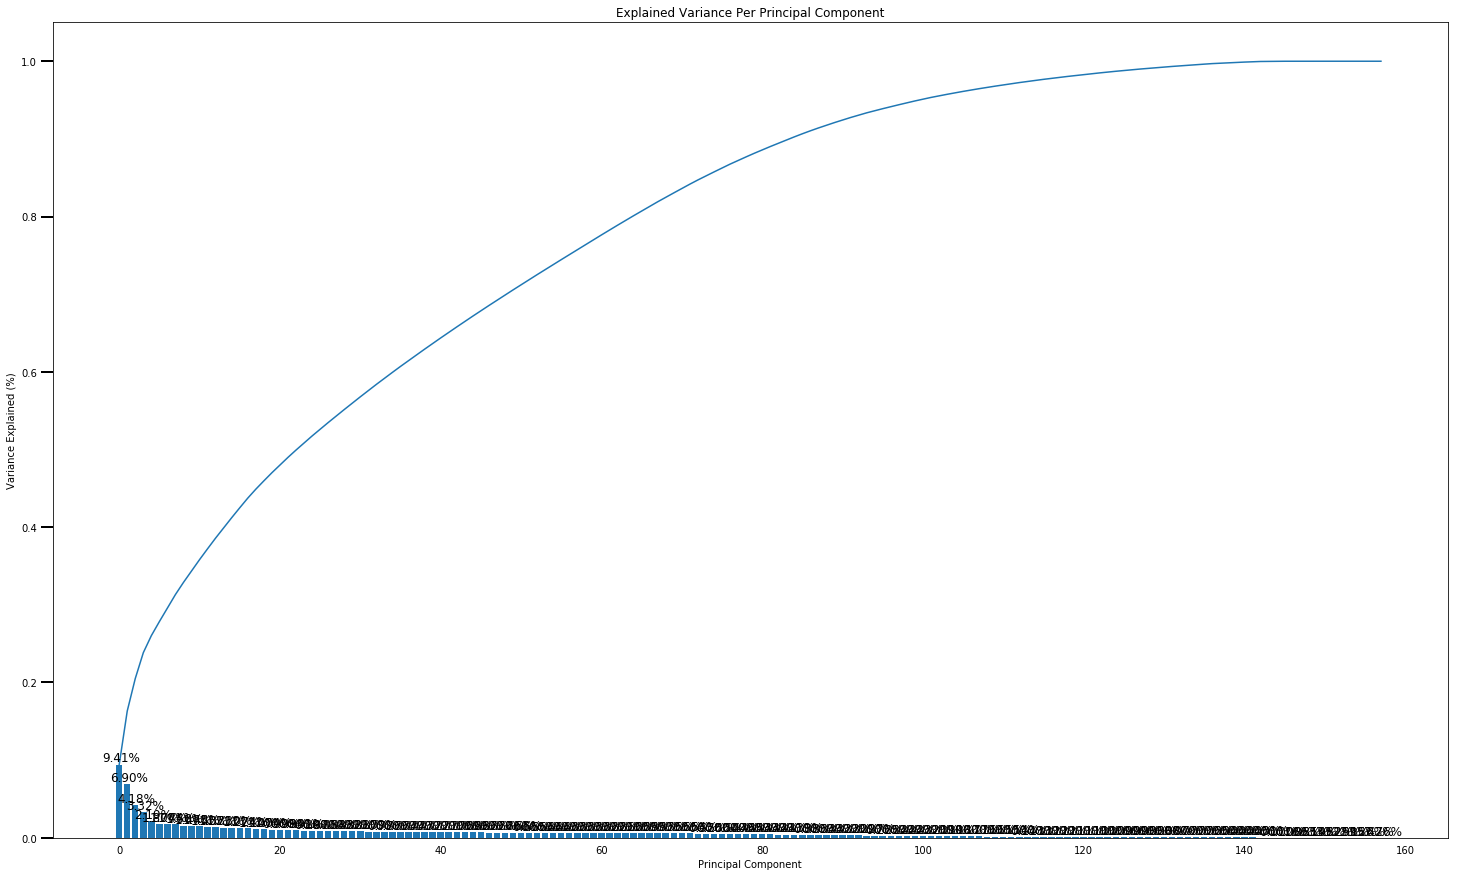

In [188]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(25, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

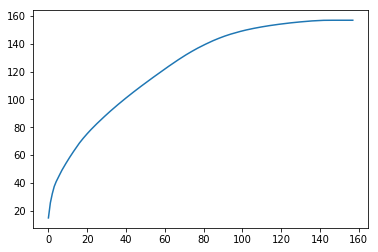

In [189]:
plt.plot(np.cumsum(abs(pca.explained_variance_)));

Text(0,0.5,'Cumulative Explained Variance')

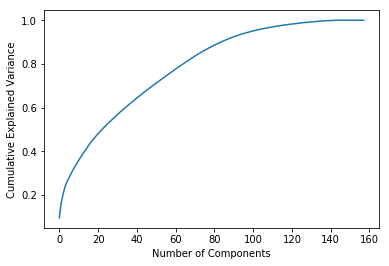

In [190]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [191]:
# Re-apply PCA to the data while selecting for number of components to retain.
# do pca again, reducing the amount

pca_r = PCA(100)
X_pca_r = pca_r.fit_transform(scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I will be retaining 100 principal components of this dataset as that accounts for about 90% of the variance. This is because as shown above by the scree plot, as it reaches around 100 pca's, it levels off.

Looking at the plot, we can see that after 100, the increase of variance explained drops majorly, so we can therefore stop at 100 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [192]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#pca_r.components_[1]


In [193]:
def map_weight_feats(pca_obj, df, component):
    '''
    INPUT: 
        pca_obj - Fit PCA object
        df - DataFrame with full data
        component - integer (starting at 0) of component
    OUTPUT: 
        positive_comp - pandas series with positive weights
        negative_comp - pandas series with negative weights
    '''
    w = pd.DataFrame(np.round(pca_obj.components_, 6), columns=df.keys())
    comp = w.iloc[component, :]
    positive_comp = comp[comp > 0].sort_values(ascending=False)
    negative_comp = comp[comp < 0].sort_values(ascending=True)

    return positive_comp, negative_comp

In [194]:
# mape weights for first component
positive_0, negative_0 = map_weight_feats(pca_r, scaled_df, 0)

print('***Positive Values***')
print(positive_0.head(10))

print('---------------------')
print('---------------------')

print('***Negative Values***')
print(negative_0.head(10))


***Positive Values***
PLZ8_ANTG3                                                 0.194429
CAMEO_INTL_2015                                            0.190365
PLZ8_ANTG4                                                 0.187642
HH_EINKOMMEN_SCORE                                         0.182862
ORTSGR_KLS9                                                0.168231
EWDICHTE                                                   0.166214
CAMEO_INTL_2015_wealth_Poorer Households                   0.158597
FINANZ_HAUSBAUER                                           0.148120
CAMEO_INTL_2015_lifestages_Pre-Family Couples & Singles    0.145602
PLZ8_ANTG2                                                 0.134159
Name: 0, dtype: float64
---------------------
---------------------
***Negative Values***
MOBI_REGIO           -0.208711
KBA05_ANTG1          -0.194422
PLZ8_ANTG1           -0.194094
FINANZ_MINIMALIST    -0.185999
KBA05_GBZ            -0.185421
KONSUMNAEHE          -0.144337
PLZ8_GBZ             -

In [195]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
positive_1, negative_1 = map_weight_feats(pca_r, scaled_df, 1)

print('***Positive Values***')
print(positive_1.head(10))

print('---------------------')
print('---------------------')

print('***Negative Values***')
print(negative_1.head(10))


***Positive Values***
ALTERSKATEGORIE_GROB                  0.237481
FINANZ_VORSORGER                      0.226322
ZABEOTYP_3.0                          0.201521
SEMIO_ERL                             0.183604
SEMIO_LUST                            0.166933
RETOURTYP_BK_S                        0.159251
W_KEIT_KIND_HH                        0.121419
PRAEGENDE_JUGENDJAHRE_decades_60.0    0.120065
CJT_GESAMTTYP_2.0                     0.110733
PRAEGENDE_JUGENDJAHRE_decades_50.0    0.107418
Name: 1, dtype: float64
---------------------
---------------------
***Negative Values***
FINANZ_SPARER                        -0.230413
SEMIO_REL                            -0.217667
FINANZ_UNAUFFAELLIGER                -0.217449
SEMIO_TRADV                          -0.212801
SEMIO_PFLICHT                        -0.209247
FINANZ_ANLEGER                       -0.207528
PRAEGENDE_JUGENDJAHRE_decades_90.0   -0.205761
SEMIO_RAT                            -0.170934
SEMIO_KULT                           -0.16

In [196]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
positive_2, negative_2 = map_weight_feats(pca_r, scaled_df, 2)

print('***Positive Values***')
print(positive_2.head(10))

print('***Positive Lowest***')
print(positive_2.tail(5))

print('---------------------')
print('---------------------')

print('***Negative Values***')
print(negative_2.head(10))




***Positive Values***
SEMIO_VERT           0.330067
SEMIO_FAM            0.263330
SEMIO_SOZ            0.261321
SEMIO_KULT           0.253461
FINANZ_MINIMALIST    0.144040
FINANZTYP_5.0        0.139155
SEMIO_REL            0.112303
GREEN_AVANTGARDE     0.089588
SEMIO_MAT            0.089210
RETOURTYP_BK_S       0.077482
Name: 2, dtype: float64
***Positive Lowest***
PRAEGENDE_JUGENDJAHRE_decades_70.0                             0.001494
SOHO_KZ                                                        0.000864
GEBAEUDETYP_5.0                                                0.000573
LP_FAMILIE_FEIN_9.0                                            0.000249
CAMEO_INTL_2015_lifestages_Older Families &  Mature Couples    0.000197
Name: 2, dtype: float64
---------------------
---------------------
***Negative Values***
ANREDE_KZ            -0.353615
SEMIO_KAEM           -0.322673
SEMIO_DOM            -0.287957
SEMIO_KRIT           -0.268794
SEMIO_ERL            -0.205926
SEMIO_RAT            -0.160

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For these weights, we can see that those with higher weights are similar and are correlated. For instance `SEMIO_VERT` and `SEMIO_FAM` both have `0.329` and `0.265` weights (top highest on the 3rd component) have the same description (affinity). In contrast, these have no correlation to `SOHO_KZ` with a weight of `0.000939` which has the description of `small office/home office`.

For the first Component, things such as the number of family houses, lifestage typology, and number of 10+ family houses are top explained variances. Also these are highly correlated with each other. In contrast, neighborhood typology, and number of 1-2 family houses have the least amount of variance explained and also are correlated with each other. What is interesting for the first principal component is that the number of family houses feature and the number of 1-2 family houses are not correlated at all.

For the second component, estimated age, and financial typology account for those with the most variance explained while those that do not contribute much with information is financial typlogy and personality type. What is interesting is that the two financial typlogies are on the opposite end of the spectrum (two different variables which explain the same thing).

For the third component, personality type alone makes up the major explanations of th data. In those that do not have much impact, gender, and again personality type. This is possibly because some of these variables were already used.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [197]:
# Over a number of different cluster counts...
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(X_pca_r)
score = np.abs(model.score(X_pca_r))

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 1.44 ms


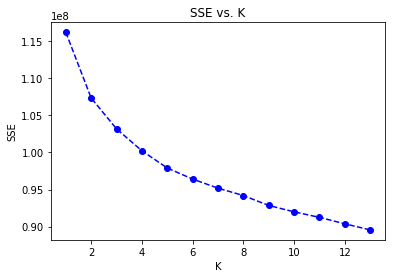

In [198]:
# THIS CELL WORKS! JUST COMMENTING BECAUSE IT TAKES TOO LONG TO TRAIN. TOOK PICTURE OF PLOT TO SHOW WHAT IS NEEDED

%time

# MY WORK: testing this out on my own
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,14))

for center in centers:
    scores.append(get_kmeans_score(X_pca_r, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [199]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(6)
model = kmeans.fit(X_pca_r)
labels = model.predict(X_pca_r)



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I decided to segment the population into 6 clusters, for as shown in the elbow chart, this was where the decline started to level out.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [200]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [201]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# wrangling, encoding, feature transformation
customer_cleaned, customer_high_nan = clean_data(customers)

# impute customer data
#mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

#imputed_customers = mean_imputer.fit_transform(customer_cleaned.values)
imputed_customers = mean_imputer.transform(customer_cleaned.values)


imputed_customers = pd.DataFrame(imputed_customers)

imputed_customers.columns = customer_cleaned.columns

# Apply feature scaling
scaled_values = scaler.transform(imputed_customers.values)

customers = pd.DataFrame(scaled_values)
customers.columns = imputed_customers.columns


customers.head()





# pca



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,1.181706,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.817895,1.882535,-1.630686,...,-0.380761,-0.678945,-0.455436,-0.32105,1.915187,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115
1,1.181706,0.958395,1.414618,-1.151087,1.133828,-1.247812,0.980071,0.611953,1.882535,-0.276116,...,2.626321,-0.678945,-0.455436,-0.32105,-0.522142,-0.1401,-0.314584,3.795025,-0.27964,-0.377115
2,1.181706,-1.043411,1.414618,-1.151087,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.380761,-0.678945,-0.455436,-0.32105,1.915187,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115
3,0.198771,-1.043411,-0.036761,-1.151087,0.407468,0.788502,1.697599,-0.817895,-0.531199,1.078455,...,-0.380761,1.472874,-0.455436,-0.32105,-0.522142,-0.1401,3.178797,-0.263503,-0.27964,-0.377115
4,0.198771,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.102971,1.882535,1.078455,...,-0.380761,-0.678945,-0.455436,-0.32105,-0.522142,-0.1401,-0.314584,-0.263503,-0.27964,-0.377115


In [202]:
# apply pca
X_customers = pca_r.transform(customers)

In [203]:
customers_0_positive, customers_0_negative = map_weight_feats(pca_r,customers, 0)

In [204]:
print('***Positive Customers 0***')
print(customers_0_positive.head(3))

print('***Negative Customers 0***')
print(customers_0_negative.head(3))

***Positive Customers 0***
PLZ8_ANTG2     0.194429
OST_WEST_KZ    0.190365
PLZ8_ANTG3     0.187642
Name: 0, dtype: float64
***Negative Customers 0***
KKK                -0.208711
CAMEO_INTL_2015    -0.194422
KBA13_ANZAHL_PKW   -0.194094
Name: 0, dtype: float64


In [205]:
# predict the kmeans using the model from the generic data
customer_labels = model.predict(X_customers)

In [206]:
len(customer_labels)

138454

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [207]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# how much persons are assigned to each cluster?

# attach the labels onto the general dataframe
l = pd.DataFrame(labels)
general_data_joined = scaled_df.join(l)



In [208]:
# join for the customers data
o = pd.DataFrame(customer_labels)
customer_data_joined = customers.join(o)

In [209]:
# lets get the data with missing or high values and add the column 0, giving the values '-1'
azdias_g40[0] = -1

# concatenate the two dataframes
master_general_df = pd.concat([general_data_joined, azdias_g40], ignore_index=True)

master_general_df.head(1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_GESAMTTYP_2.0,...,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,PLZ8_BAUMAX
0,-1.767099,0.958395,0.163066,-0.126267,0.229631,-0.060808,-0.175058,0.848197,1.09874,-0.466914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
customer_high_nan[0] = -1

master_customer_df = pd.concat([customer_data_joined,customer_high_nan], ignore_index=True)

In [211]:
# Find the proportions of customer data
master_customer_df[0].value_counts(normalize=True).sort_values()

 4    0.000047
 2    0.000120
 3    0.002066
 5    0.006032
-1    0.277576
 1    0.714159
Name: 0, dtype: float64

In [212]:
master_general_df[0].value_counts(normalize=True).sort_values()

-1    0.124625
 1    0.125309
 3    0.135473
 5    0.137184
 0    0.151267
 4    0.162811
 2    0.163332
Name: 0, dtype: float64

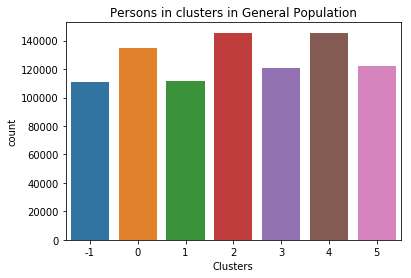

In [213]:
import seaborn as sns
ax = sns.countplot(data=master_general_df, x = 0)
ax.set_title('Persons in clusters in General Population');
ax.set_xlabel('Clusters');


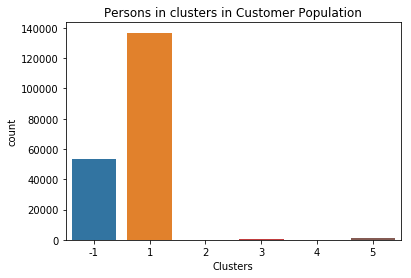

In [214]:
ax = sns.countplot(data=master_customer_df, x = 0)
ax.set_title('Persons in clusters in Customer Population');
ax.set_xlabel('Clusters');

In [215]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_4 = customer_data_joined[customer_data_joined[0] == 4]
cluster_4.drop(0, inplace=True, axis=1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [216]:
pos_4, neg_4 = map_weight_feats(pca_r,cluster_4, 0)

In [217]:
print(pos_4.head(5))

PLZ8_ANTG2     0.194429
OST_WEST_KZ    0.190365
PLZ8_ANTG3     0.187642
ANZ_TITEL      0.182862
ARBEIT         0.168231
Name: 0, dtype: float64


In [218]:
cluster_3 = customer_data_joined[customer_data_joined[0] == 3]
cluster_3.drop(0, inplace=True, axis=1)

pos_3, neg_3 = map_weight_feats(pca_r,cluster_4, 0)

print(pos_3.head(5))

PLZ8_ANTG2     0.194429
OST_WEST_KZ    0.190365
PLZ8_ANTG3     0.187642
ANZ_TITEL      0.182862
ARBEIT         0.168231
Name: 0, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [219]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?




#### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

For a comparison between the 2 populations, cluster 4 in the customer dataset is overrepresented. In contrast every other cluster in the customer dataset is underrepresented.

In the customer data, those that are overrepresented are those that have 6-10 family houses, and have very low to very highunenployment in the homes.

Those who are unrerepresented are those with 3-5 family houses and have very low to high unenployment rates.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.